Processing images: 100%|██████████| 10/10 [01:10<00:00,  7.10s/it]


کل بیت‌ها: 62720
خطا قبل از دیکدینگ: 11680
خطا بعد از دیکدینگ: 5619


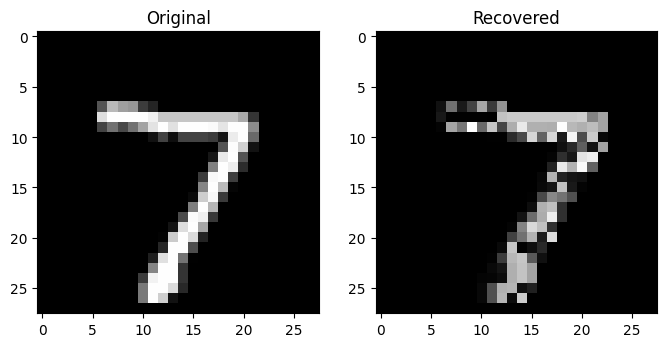

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tqdm import tqdm

# --- 1. بارگذاری MNIST ---
(x_train, _), (x_test, _) = mnist.load_data()
images = x_test[:10]  # مثال با 10 تصویر
h, w = images.shape[1], images.shape[2]

# --- 2. تبدیل تصویر به باینری ---
def image_to_bits(image):
    return np.array([int(b) for pixel in image.flatten() for b in format(pixel, '08b')])

def bits_to_image(bits, shape):
    pixels = [int("".join(map(str, bits[i:i+8])), 2) for i in range(0, len(bits), 8)]
    return np.array(pixels, dtype=np.uint8).reshape(shape)

# --- 3. تعریف کد کانولوشنال (rate=1/2, constraint length=5) ---
def conv_encode(bits):
    g1 = np.array([1,1,1,1,1])  # generator polynomial
    g2 = np.array([1,0,1,0,1])  # generator polynomial
    K = len(g1)
    bits = np.concatenate([np.zeros(K-1, dtype=int), bits])  # padding
    encoded = []
    for i in range(len(bits)-K+1):
        window = bits[i:i+K]
        encoded.append(np.sum(window*g1)%2)
        encoded.append(np.sum(window*g2)%2)
    return np.array(encoded, dtype=int)

# --- 4. دیکدینگ Viterbi soft-decision ---
def viterbi_decode_soft(encoded_bits):
    K = 5
    n = 2
    num_states = 2**(K-1)
    inf = 1e9

    # تبدیل بیت‌ها به soft values (-1, +1)
    recv = 2*encoded_bits - 1

    path_metric = np.full(num_states, inf)
    path_metric[0] = 0
    paths = [[] for _ in range(num_states)]

    for i in range(0, len(encoded_bits), n):
        recv_pair = recv[i:i+n]
        new_metric = np.full(num_states, inf)
        new_paths = [[] for _ in range(num_states)]
        for state in range(num_states):
            for bit in [0,1]:
                prev_state = ((state>>1) | (bit<<(K-2))) & (num_states-1)
                # تولید خروجی encoder
                bits_window = [int(x) for x in format(prev_state, f'0{K-1}b')] + [bit]
                g1 = np.array([1,1,1,1,1])
                g2 = np.array([1,0,1,0,1])
                out = 2*np.array([np.sum(bits_window*g1)%2, np.sum(bits_window*g2)%2]) - 1
                metric = path_metric[prev_state] + np.sum((out - recv_pair)**2)
                if metric < new_metric[state]:
                    new_metric[state] = metric
                    new_paths[state] = paths[prev_state] + [bit]
        path_metric = new_metric
        paths = new_paths

    best_state = np.argmin(path_metric)
    return np.array(paths[best_state], dtype=int)

# --- 5. شبیه‌سازی نویز ---
def add_noise(encoded_bits, error_prob=0.01):
    noisy = np.copy(encoded_bits)
    errors = np.random.rand(len(encoded_bits)) < error_prob
    noisy[errors] = 1 - noisy[errors]
    return noisy

# --- 6. پردازش تصاویر ---
recovered_images = []
bit_errors_before = 0
bit_errors_after = 0

for img in tqdm(images, desc="Processing images"):
    data = image_to_bits(img)
    encoded = conv_encode(data)
    noisy = add_noise(encoded, error_prob=0.01)
    # شمارش خطا قبل از دیکدینگ
    bit_errors_before += np.sum(data != noisy[:len(data)])
    # دیکدینگ soft-decision
    decoded = viterbi_decode_soft(noisy)
    # شمارش خطا بعد از دیکدینگ
    bit_errors_after += np.sum(data != decoded[:len(data)])
    recovered_images.append(bits_to_image(decoded, (h,w)))

# --- 7. نمایش نتایج ---
print(f"کل بیت‌ها: {len(images)*h*w*8}")
print(f"خطا قبل از دیکدینگ: {bit_errors_before}")
print(f"خطا بعد از دیکدینگ: {bit_errors_after}")

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(images[0], cmap='gray')
plt.subplot(1,2,2); plt.title("Recovered"); plt.imshow(recovered_images[0], cmap='gray')
plt.show()
